In [ ]:
# https://rest.ensembl.org/documentation/info/genomic_alignment_region
import requests, sys
server = "https://rest.ensembl.org"

In [ ]:
import time, requests, json, ast

# from prettytable import PrettyTable
import pandas as pd
import numpy as np

In [ ]:
inputdf = pd.read_csv("novel_exon_end_locations_motifs.csv")

In [ ]:
inputdf['gene'] = inputdf['gene_names']
inputdf['chr'] = inputdf['chr'].str.replace('chr', '')
inputdf['ext'] = '/alignment/region/homo_sapiens/' + inputdf['chr'].astype(str) + ':' + inputdf['splice_site_5p_lower_coordinate'].astype(str) + '-' + inputdf['splice_site_5p_upper_coordinate'].astype(str) + '?species_set=homo_sapiens;species_set=macaca_fascicularis;method=LASTZ_NET'
mydf = inputdf.loc[:, ['gene', 'ext']]
mydf.head()

In [ ]:
%%time
results = []
bad_requests = []

for index, row in mydf.iterrows():
    gene = row['gene']
    ext = row['ext']
    try:
        r = requests.get(server + ext, headers={"Content-Type": "application/json"})
        r.raise_for_status()
        decoded = r.json()
        result_entry = {'gene': gene, 'decoded': decoded}
        results.append(result_entry)
    except requests.exceptions.HTTPError as err:
        print(f"Skipping row with gene {gene} and ext {ext} due to bad request.")
        bad_requests.append(row)

ensembl_output = pd.DataFrame(results)
bad_request_df = pd.DataFrame(bad_requests)

# # print("Ensembl Output:")
# print(ensembl_output)
# # print("\nBad Requests:")
# print(bad_request_df)

# CPU times: user 49.5 s, sys: 1.02 s, total: 50.5 s
# Wall time: 8min 47s

KeyboardInterrupt: 

In [ ]:
ensembl_output.shape # 549
ensembl_output.head()

,gene,decoded
0,ABCB8,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
1,ABHD13,"[{'alignments': [{'description': '', 'start': ..."
2,ACACA,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
3,ADGRF5,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
4,AHCY,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."


In [ ]:
bad_request_df.shape # 33

(33, 2)

In [ ]:
# save on 05/14
excel_file = "ensembl_human_cyno_goodbad_match.xlsx"
with pd.ExcelWriter(excel_file) as writer:
    ensembl_output.to_excel(writer, sheet_name='good_request', index=False)
    bad_request_df.to_excel(writer, sheet_name='bad_request', index=False)

In [ ]:
# 05/15
# read in the above output
good = pd.read_excel("ensembl_human_cyno_goodbad_match.xlsx", sheet_name='good_request')
bad = pd.read_excel("ensembl_human_cyno_goodbad_match.xlsx", sheet_name='bad_request')

In [ ]:
good.head()

,gene,decoded
0,ABCB8,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
1,ABHD13,"[{'alignments': [{'description': '', 'start': ..."
2,ACACA,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
3,ADGRF5,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."
4,AHCY,"[{'tree': '(homo_sapiens:0,macaca_fascicularis..."


In [ ]:
def parseme(decoded):
    homo_chr, homo_start, homo_end, homo_seq = None, None, None, None
    cyno_chr, cyno_start, cyno_end, cyno_seq = None, None, None, None

    for entry in decoded:
        for alignment in entry.get('alignments', []):
            species = alignment['species']
            seq = alignment['seq']
            start = alignment['start']
            end = alignment['end']
            seq_region = alignment['seq_region']

            if species == 'homo_sapiens':
                homo_chr = seq_region
                homo_start = start
                homo_end = end
                homo_seq = seq
            elif species == 'macaca_fascicularis':
                cyno_chr = seq_region
                cyno_start = start
                cyno_end = end
                cyno_seq = seq

    # print("Debug - Values extracted:")
    # print("Homo sapiens:", homo_chr, homo_start, homo_end, homo_seq)
    # print("Macaca fascicularis:", cyno_chr, cyno_start, cyno_end, cyno_seq)

    return {
        'homo_chr': homo_chr,
        'homo_start': homo_start,
        'homo_end': homo_end,
        'homo_seq': homo_seq,
        'cyno_chr': cyno_chr,
        'cyno_start': cyno_start,
        'cyno_end': cyno_end,
        'cyno_seq': cyno_seq
    }

processed = []
for gene, decoded_str in zip(good['gene'], good['decoded']):
    decoded = ast.literal_eval(decoded_str)  # Convert string to dictionary
    processed.append({'gene': gene, **parseme(decoded)})

goodclean = pd.DataFrame(processed)
goodclean


,gene,homo_chr,homo_start,homo_end,homo_seq,cyno_chr,cyno_start,cyno_end,cyno_seq
0,ABCB8,7,151033059,151033063,CAGGT,3,178166530,178166534,CAAGT
1,ABHD13,13,108221452,108221456,AGAGT,17,89464798,89464802,AGAGT
2,ACACA,17,37235463,37235467,ACTCT,16,33099177,33099181,ACTCT
3,ADGRF5,6,46900671,46900675,ACTCT,4,122555564,122555568,ACTTT
4,AHCY,20,34282350,34282354,ACCTT,10,66836350,66836354,ACCTT
...,...,...,...,...,...,...,...,...,...
544,ZMYND8,20,47292669,47292673,A------------------CTCT,10,79792338,79792360,AATGGATTTAGACAGCAAATTCT
545,ZNF212,7,149249418,149249422,GATGT,3,176796721,176796725,GATGT
546,ZNF512,2,27619726,27619730,AGTGT,13,80657275,80657279,AGTGT
547,ZNF839,14,102322840,102322844,CAGGT,X,2514434,2514438,CAGGT


In [ ]:
# if 'strand' in cyno is '-1' meaning it's the opposite strand as the human input
def strandme(decoded):
    for entry in decoded:
        if 'alignments' in entry:
            for alignment in entry['alignments']:
                species = alignment.get('species')
                strand = alignment.get('strand')
                # print("Species:", species)
                # print("Strand:", strand)
                if species == 'macaca_fascicularis' and strand is not None:
                    return 'opposite' if strand == -1 else 'same'
    return None

# Convert the 'decoded' column from string to dictionary
good['decoded'] = good['decoded'].apply(ast.literal_eval)

# Apply the function to each row in 'decoded' column
goodclean['cyno_strand'] = good['decoded'].apply(strandme)
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand
0,ABCB8,7,151033059,151033063,CAGGT,3,178166530,178166534,CAAGT,same
1,ABHD13,13,108221452,108221456,AGAGT,17,89464798,89464802,AGAGT,same
2,ACACA,17,37235463,37235467,ACTCT,16,33099177,33099181,ACTCT,opposite
3,ADGRF5,6,46900671,46900675,ACTCT,4,122555564,122555568,ACTTT,opposite
4,AHCY,20,34282350,34282354,ACCTT,10,66836350,66836354,ACCTT,same


In [ ]:
inputdf.head()

# Merge inputdf with goodclean based on 'gene_names' and 'gene'
merged_df = pd.merge(goodclean, inputdf, left_on='gene', right_on='gene_names', how='left')

# Match string to add 'strand' into 'goodclean'
goodclean['homo_strand'] = merged_df['strand']
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand,homo_strand
0,ABCB8,7,151033059,151033063,CAGGT,3,178166530,178166534,CAAGT,same,+
1,ABHD13,13,108221452,108221456,AGAGT,17,89464798,89464802,AGAGT,same,+
2,ACACA,17,37235463,37235467,ACTCT,16,33099177,33099181,ACTCT,opposite,-
3,ADGRF5,6,46900671,46900675,ACTCT,4,122555564,122555568,ACTTT,opposite,-
4,AHCY,20,34282350,34282354,ACCTT,10,66836350,66836354,ACCTT,same,-


In [ ]:
# Move the 'strand' column to the second position
strand_column = goodclean.pop('homo_strand')  # Remove 'strand' column from DataFrame
goodclean.insert(5, 'homo_strand', strand_column)  # Insert 'strand' column at index 5
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,homo_strand,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand
0,ABCB8,7,151033059,151033063,CAGGT,+,3,178166530,178166534,CAAGT,same
1,ABHD13,13,108221452,108221456,AGAGT,+,17,89464798,89464802,AGAGT,same
2,ACACA,17,37235463,37235467,ACTCT,-,16,33099177,33099181,ACTCT,opposite
3,ADGRF5,6,46900671,46900675,ACTCT,-,4,122555564,122555568,ACTTT,opposite
4,AHCY,20,34282350,34282354,ACCTT,-,10,66836350,66836354,ACCTT,same


In [ ]:
# Convert 'cyno_strand': if "same", copy 'homo_strand'; if "opposite", write the opposite of 'homo_strand'
def findstrand(row):
    if row['cyno_strand'] == 'same':
        return row['homo_strand']
    elif row['cyno_strand'] == 'opposite':
        return '-' if row['homo_strand'] == '+' else '+'

# Apply the function to each row in the DataFrame
goodclean['cyno_strand'] = goodclean.apply(findstrand, axis=1)
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,homo_strand,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand
0,ABCB8,7,151033059,151033063,CAGGT,+,3,178166530,178166534,CAAGT,+
1,ABHD13,13,108221452,108221456,AGAGT,+,17,89464798,89464802,AGAGT,+
2,ACACA,17,37235463,37235467,ACTCT,-,16,33099177,33099181,ACTCT,+
3,ADGRF5,6,46900671,46900675,ACTCT,-,4,122555564,122555568,ACTTT,+
4,AHCY,20,34282350,34282354,ACCTT,-,10,66836350,66836354,ACCTT,-


In [ ]:
# Add a column 'homo_seq_strand': if 'homo_strand' is '+', copy 'homo_seq' into 'homo_seq_strand';
# if 'homo_strand' is '-', step 1: convert 'homo_seq' based on the following rule A to T, T to A, C to G, G to C, step 2: reverse the order and write into 'homo_seq_strand'

def convertseq_tostrand(row):
    homo_seq = row['homo_seq']
    if row['homo_strand'] == '-':
        # Convert bases according to the rule
        homo_seq = homo_seq.translate(str.maketrans('ATCG', 'TAGC'))
        # Reverse the sequence
        homo_seq = homo_seq[::-1]
    return homo_seq

# Apply the function to each row in the DataFrame
goodclean['homo_seq_strand'] = goodclean.apply(convertseq_tostrand, axis=1)
goodclean.head()

In [ ]:
# Move goodclean['homo_seq_strand'] behind 'homo_strand' (index 6)
strand_column = goodclean.pop('homo_seq_strand')  # Remove 'strand' column from DataFrame
goodclean.insert(6, 'homo_seq_strand', strand_column)
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,homo_strand,homo_seq_strand,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand
0,ABCB8,7,151033059,151033063,CAGGT,+,CAGGT,3,178166530,178166534,CAAGT,+
1,ABHD13,13,108221452,108221456,AGAGT,+,AGAGT,17,89464798,89464802,AGAGT,+
2,ACACA,17,37235463,37235467,ACTCT,-,AGAGT,16,33099177,33099181,ACTCT,+
3,ADGRF5,6,46900671,46900675,ACTCT,-,AGAGT,4,122555564,122555568,ACTTT,+
4,AHCY,20,34282350,34282354,ACCTT,-,AAGGT,10,66836350,66836354,ACCTT,-


In [ ]:
# Add a column 'cyno_seq_strand': if 'cyno_strand' is '+', copy 'cyno_seq' into 'cyno_seq_strand';
# if 'cyno_strand' is '-', step 1: convert 'cyno_seq' based on the following rule A to T, T to A, C to G, G to C, step 2: reverse the order and write into 'cyno_seq_strand'

def convertseq_tostrand_cyno(row):
    cyno_seq = row['cyno_seq']
    if row['cyno_strand'] == '-':
        # Convert bases according to the rule
        cyno_seq = cyno_seq.translate(str.maketrans('ATCG', 'TAGC'))
        # Reverse the sequence
        cyno_seq = cyno_seq[::-1]
    return cyno_seq

# Apply the function to each row in the DataFrame
goodclean['cyno_seq_strand'] = goodclean.apply(convertseq_tostrand_cyno, axis=1)
goodclean.head()

,gene,homo_chr,homo_start,homo_end,homo_seq,homo_strand,homo_seq_strand,cyno_chr,cyno_start,cyno_end,cyno_seq,cyno_strand,cyno_seq_strand
0,ABCB8,7,151033059,151033063,CAGGT,+,CAGGT,3,178166530,178166534,CAAGT,+,CAAGT
1,ABHD13,13,108221452,108221456,AGAGT,+,AGAGT,17,89464798,89464802,AGAGT,+,AGAGT
2,ACACA,17,37235463,37235467,ACTCT,-,AGAGT,16,33099177,33099181,ACTCT,+,ACTCT
3,ADGRF5,6,46900671,46900675,ACTCT,-,AGAGT,4,122555564,122555568,ACTTT,+,ACTTT
4,AHCY,20,34282350,34282354,ACCTT,-,AAGGT,10,66836350,66836354,ACCTT,-,AAGGT


In [ ]:
# ===================================================================================
# As of now, data processing is finished -> start analyzing similarity
# save on 05/15
excel_file = "ensembl_human_cyno_motif.xlsx"
with pd.ExcelWriter(excel_file) as writer:
    goodclean.to_excel(writer, sheet_name='matched', index=False)

In [ ]:
# Create a new df for comparison
humancyno = goodclean[['gene', 'homo_seq_strand', 'cyno_seq_strand']].copy()
humancyno.columns = ['gene', 'human', 'cyno']
humancyno.head()

,gene,human,cyno
0,ABCB8,CAGGT,CAAGT
1,ABHD13,AGAGT,AGAGT
2,ACACA,AGAGT,ACTCT
3,ADGRF5,AGAGT,ACTTT
4,AHCY,AAGGT,AAGGT


In [ ]:
# Check if last two letters of 'cyno' end with "GT"
humancyno['cyno_GT'] = humancyno['cyno'].apply(lambda x: 'GT' if x[-2:] == 'GT' else '-')
# goodclean['cyno_GT']
humancyno.head()

,gene,human,cyno,cyno_GT
0,ABCB8,CAGGT,CAAGT,GT
1,ABHD13,AGAGT,AGAGT,GT
2,ACACA,AGAGT,ACTCT,-
3,ADGRF5,AGAGT,ACTTT,-
4,AHCY,AAGGT,AAGGT,GT


In [ ]:
# Check if 'cyno' starts with "AGA"
humancyno['cyno_AGA'] = humancyno['cyno'].apply(lambda x: 'AGA' if x.startswith('AGA') else '-')
humancyno.head()

,gene,human,cyno,cyno_GT,cyno_AGA
0,ABCB8,CAGGT,CAAGT,GT,-
1,ABHD13,AGAGT,AGAGT,GT,AGA
2,ACACA,AGAGT,ACTCT,-,-
3,ADGRF5,AGAGT,ACTTT,-,-
4,AHCY,AAGGT,AAGGT,GT,-


In [ ]:
# Add a column called 'cyno_GT_simi': if 'cyno_GT' is 'GT', compare 'human' with 'cyno' for exact match,
# if 1 exact match, write 20% to column 'cyno_GT_simi', 2 match 40%, 3 match 60%, 4 match 80%, and 5 matches for 100%; if 'cyno_GT' is '-', write '-' into 'cyno_GT_simi'

def simi(row):
    if row['cyno_GT'] == 'GT':
        matches = sum(a == b for a, b in zip(row['human'], row['cyno']))
        similarity = min(matches / len(row['human']), 1.0)
        return similarity * 100
    else:
        return '-'

# Apply the function to each row
humancyno['cyno_GT_simi'] = humancyno.apply(simi, axis=1)
humancyno.head()

,gene,human,cyno,cyno_GT,cyno_AGA,cyno_GT_simi,cyno_simi
0,ABCB8,CAGGT,CAAGT,GT,-,80.0,80.0
1,ABHD13,AGAGT,AGAGT,GT,AGA,100.0,100.0
2,ACACA,AGAGT,ACTCT,-,-,-,40.0
3,ADGRF5,AGAGT,ACTTT,-,-,-,40.0
4,AHCY,AAGGT,AAGGT,GT,-,100.0,100.0


In [ ]:
# Add a column called 'cyno_simi': compare 'human' with 'cyno' for exact match,
# if 0 match write '-' to column 'cyno_simi', 1 match 20%, 2 match 40%, 3 match 60%, 4 match 80%, and 5 matches for 100%

def overallsimi(row):
    matches = sum(a == b for a, b in zip(row['human'], row['cyno']))
    similarity = min(matches / len(row['human']), 1.0)
    return similarity * 100

# Apply the function to each row
humancyno['cyno_simi'] = humancyno.apply(overallsimi, axis=1)
humancyno.head()

,gene,human,cyno,cyno_GT,cyno_AGA,cyno_GT_simi,cyno_simi
0,ABCB8,CAGGT,CAAGT,GT,-,80.0,80.0
1,ABHD13,AGAGT,AGAGT,GT,AGA,100.0,100.0
2,ACACA,AGAGT,ACTCT,-,-,-,40.0
3,ADGRF5,AGAGT,ACTTT,-,-,-,40.0
4,AHCY,AAGGT,AAGGT,GT,-,100.0,100.0


In [ ]:
# humancyno
# save on 05/15
excel_file = "ensembl_human_cyno_similarity.xlsx"
with pd.ExcelWriter(excel_file) as writer:
    humancyno.to_excel(writer, sheet_name='motif', index=False)

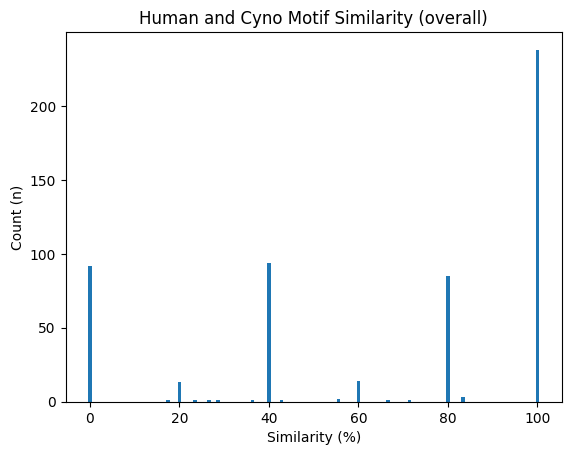

In [ ]:
# Plot a line chart of the 'cyno_simi' values ranging from 0 to 100
# y axis as count, x axis is similarity

import matplotlib.pyplot as plt
from collections import Counter

# Counting occurrences of each similarity value
similarity_count = Counter(humancyno['cyno_simi'])

# Extracting x and y values
x_values = list(similarity_count.keys())
y_values = list(similarity_count.values())

# # Plotting the line chart
# plt.plot(x_values, y_values)

# Plotting the bar chart
plt.bar(x_values, y_values)

# Adding title and labels
plt.title('Human and Cyno Motif Similarity (overall)')
plt.xlabel('Similarity (%)')
plt.ylabel('Count (n)')

# # Displaying the plot
# plt.show()

plt.savefig("humancyno_motif_overallsimi.pdf", bbox_inches='tight')

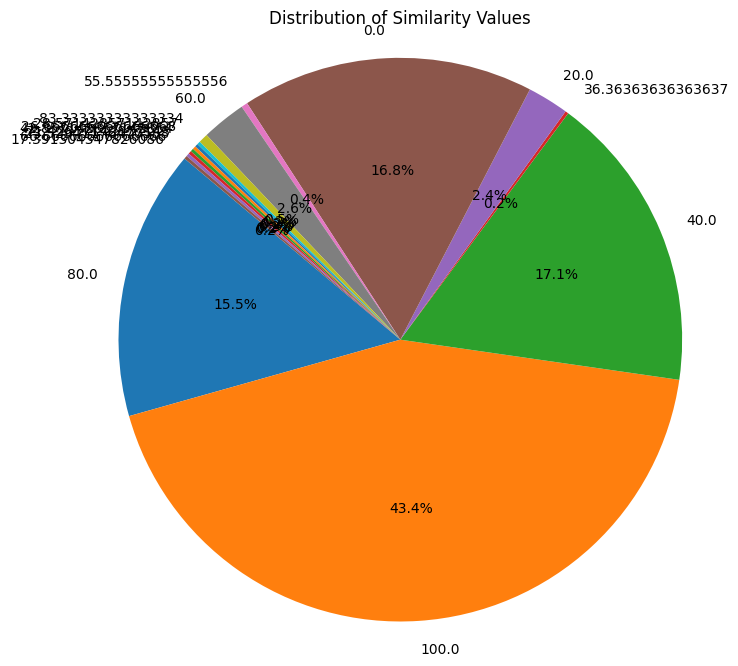

In [ ]:
# Create a pie chart

plt.figure(figsize=(8, 8))
plt.pie(similarity_count.values(), labels=similarity_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Similarity Values')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

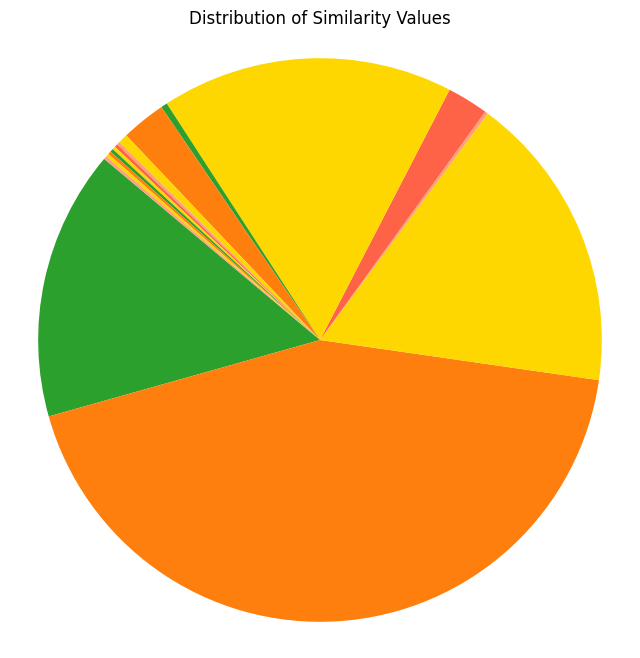

In [ ]:
# Create a pie chart - no label

colors = ['#2CA02C', '#FF7F0E', '#FFD700', '#FFA07A', '#FF6347', '#FFD700']

plt.figure(figsize=(8, 8))
plt.pie(similarity_count.values(), startangle=140, colors=colors)
plt.title('Distribution of Similarity Values')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()